# Initializations

In [1]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
import pandas as pd
from IPython.display import Image, display
from sklearn.metrics import average_precision_score, accuracy_score, precision_recall_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from xml.etree import ElementTree as ET
import gc
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

ANNOTATION_DIR ='VOCdevkit/VOC2008/Annotations'
LABELS_DIR     = 'VOCdevkit/VOC2008/ImageSets/Main'
TRAIN_DIR = 'VOCdevkit/VOC2008/ImageSets/Main/train.txt'
VAL_DIR ='VOCdevkit/VOC2008/ImageSets/Main/val.txt'
IMAGES_DIR = 'VOCdevkit/VOC2008/JPEGImages'
OUTPUT_DIR='dataset.csv'

tf.keras.utils.set_random_seed(42)

# It gives warning when a batch does not have any positives which is quite often
warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds.")


2024-02-24 08:46:26.323454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 08:46:26.323603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 08:46:26.500887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download Dataset

In [2]:
# Download and extract PASCAL VOC 2008 dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar
!tar -xf VOCtrainval_14-Jul-2008.tar

--2024-02-20 12:31:49--  http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577034240 (550M) [application/x-tar]
Saving to: 'VOCtrainval_14-Jul-2008.tar.1'

VOCtrainval_14-Jul- 100%[===================>] 550.30M  43.2MB/s    in 14s     

2024-02-20 12:32:03 (38.7 MB/s) - 'VOCtrainval_14-Jul-2008.tar.1' saved [577034240/577034240]



# Reading Data, And Constructing a DataFrame from it

In [17]:
labels = os.listdir(LABELS_DIR)
labels = sorted(list(set([label.split('_')[0] for label in labels if len(label.split('_')) > 1])))
print("The labels are",labels)

with open(TRAIN_DIR, "r") as f:
    train_files = [line.strip() for line in f.readlines()]

print("Training set size:", len(train_files))

with open(VAL_DIR, "r") as f:
    val_files = [line.strip() for line in f.readlines()]

print("Validation set size:", len(val_files))

The labels are ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Training set size: 2111
Validation set size: 2221


In [18]:
def extract_labels(file_names):
    targets = []
    for i, file in enumerate(tqdm(file_names)):
        targets.append([box.find('name').text for box in ET.parse(ANNOTATION_DIR + "/" + file + ".xml").getroot().iter('object')])
    return targets

train_targets = extract_labels(train_files)
val_targets = extract_labels(val_files)
targets = [*train_targets, *val_targets]

100%|██████████| 2221/2221 [00:00<00:00, 9130.54it/s]


In [19]:
df_train = pd.DataFrame({'id': train_files, 'set': 'train'})
df_val = pd.DataFrame({'id': val_files, 'set': 'val'})
df = pd.concat([df_train, df_val], ignore_index=True)
df

,id,set
0,2008_000008,train
1,2008_000015,train
2,2008_000019,train
3,2008_000023,train
4,2008_000028,train
...,...,...
4327,2008_008755,val
4328,2008_008758,val
4329,2008_008765,val
4330,2008_008767,val


In [20]:
df['target'] = targets
df['id'] = df['id'] + '.jpg'
df.to_csv(OUTPUT_DIR, index=False)

,id,set,target
0,2008_000008.jpg,train,"[horse, person]"
1,2008_000015.jpg,train,"[bottle, bottle]"
2,2008_000019.jpg,train,"[dog, dog, dog]"
3,2008_000023.jpg,train,"[tvmonitor, bottle, person, person, person]"
4,2008_000028.jpg,train,"[car, car]"
...,...,...,...
4327,2008_008755.jpg,val,"[person, person, bicycle]"
4328,2008_008758.jpg,val,"[bicycle, person]"
4329,2008_008765.jpg,val,[aeroplane]
4330,2008_008767.jpg,val,[train]


# Loading Data

In [21]:
df = pd.read_csv(OUTPUT_DIR)
df['target']=df['target'].apply(eval)
labels = os.listdir(LABELS_DIR)
labels = sorted(list(set([label.split('_')[0] for label in labels if len(label.split('_')) > 1])))
print("The labels are",labels)
df

The labels are ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


,id,set,target
0,2008_000008.jpg,train,"[horse, person]"
1,2008_000015.jpg,train,"[bottle, bottle]"
2,2008_000019.jpg,train,"[dog, dog, dog]"
3,2008_000023.jpg,train,"[tvmonitor, bottle, person, person, person]"
4,2008_000028.jpg,train,"[car, car]"
...,...,...,...
4327,2008_008755.jpg,val,"[person, person, bicycle]"
4328,2008_008758.jpg,val,"[bicycle, person]"
4329,2008_008765.jpg,val,[aeroplane]
4330,2008_008767.jpg,val,[train]


# Displaying some images along with annotations

['person', 'person', 'person', 'person', 'boat']
Image: VOCdevkit/VOC2008/JPEGImages/2008_001652.jpg


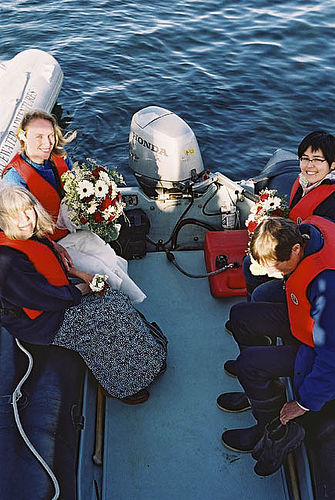

['cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow']
Image: VOCdevkit/VOC2008/JPEGImages/2008_001653.jpg


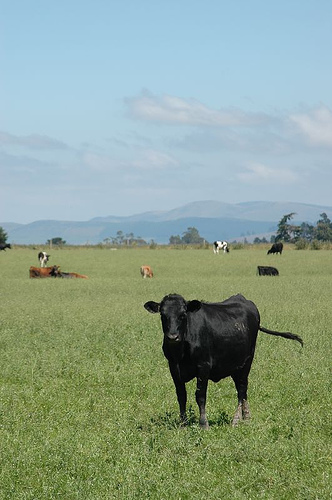

['person']
Image: VOCdevkit/VOC2008/JPEGImages/2008_001661.jpg


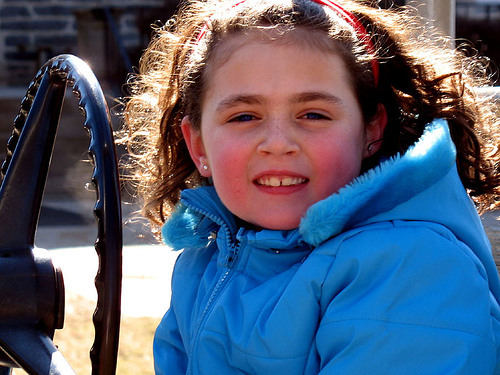

['chair', 'person', 'person', 'person', 'person', 'person', 'diningtable']
Image: VOCdevkit/VOC2008/JPEGImages/2008_001666.jpg


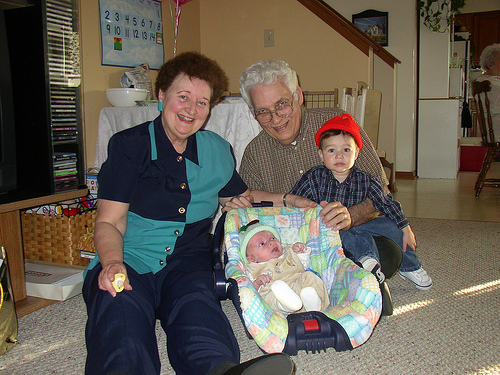

['person', 'person', 'person']
Image: VOCdevkit/VOC2008/JPEGImages/2008_001670.jpg


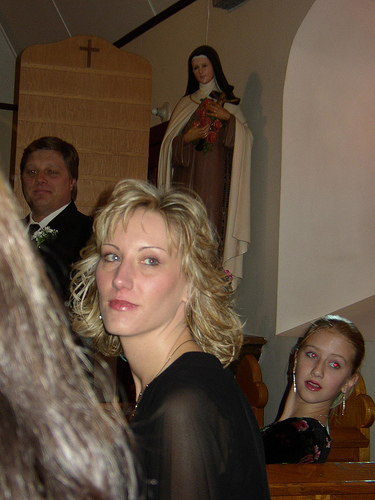

In [7]:
for i, x in df.iloc[385:390].iterrows():
    print(x['target'])
    filename = os.path.join(IMAGES_DIR, x["id"])
    print("Image:", filename)
    display(Image(filename))

# Model class to represent each label

In [3]:
class BinaryModel(tf.keras.Model):
    def __init__(self, label, folder_path=None):
        super().__init__()
        
        self.label = label
        input_shape = (224, 224, 3)
        
        if folder_path:
            model_path = os.path.join(folder_path, label + '.keras')
            if os.path.isfile(model_path):
                self._model = load_model(model_path)
                print('loaded', model_path)
        else:
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
            for layer in base_model.layers:
                layer.trainable = False
            x = base_model.output
            x = layers.GlobalAveragePooling2D()(x)
            x = layers.Dense(128, activation='relu')(x)
            x = layers.Dropout(0.5)(x)
            predictions = layers.Dense(1, activation='sigmoid')(x)

            # Create the model
            self._model = Model(inputs=base_model.input, outputs=predictions)
            self.build(input_shape=(None, *input_shape))
            
    def call(self, inputs):
        return self._model(inputs)
    
    def summary(self):
        return self._model.summary()
    
    def save(self, folder_path):
        self._model.save(os.path.join(folder_path, self.label + '.keras'))

# Defining Data Generator
They handle loading data in batches to not run out of memory. also handle the image preprocessing.

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

def create_data_generators(df, label, batch_size = 32):
    target_size = (224, 224)

    df[label] = df['target'].apply(lambda x: 1 if label in x else 0)
    
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator = datagen.flow_from_dataframe(
        directory=IMAGES_DIR,
        df[df['set'] == 'train'],
        x_col='id',
        y_col=label,
        batch_size=batch_size,
        target_size=target_size,
        class_mode='raw',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        directory=IMAGES_DIR,
        df[df['set'] == 'val'],
        x_col='id',
        y_col=label,
        batch_size=batch_size,
        target_size=target_size,
        class_mode='raw',
        shuffle=False
    )

    return train_generator, validation_generator

# Training

In [5]:
# Primary metric used to evaluate the perfomance
def AP(y_true, y_pred):
    return tf.py_function(average_precision_score, [y_true, y_pred], tf.float32)

FOLDER_PATH = 'models'
EPOCHS = 40
BATCH_SIZE = 32
OPTIMIZER = 'Adam'
LOSS = 'binary_crossentropy'
PATIENCE = 7
MIN_DELTA = 0.01
TARGET_SIZE = (224, 224, 3)

os.makedirs(FOLDER_PATH, exist_ok=True)

early_stopping = EarlyStopping(
    monitor='val_AP',
    min_delta=MIN_DELTA,
    patience=PATIENCE,
    verbose=1,
    mode='max',
    restore_best_weights=True,
    start_from_epoch=2
)


already_done_labels = [item.removesuffix('.keras') for item in os.listdir(FOLDER_PATH)]

for label in labels:
    
    if label in already_done_labels:
        print("skipping", label)
        continue
        
    print("training", label)
    
    model = BinaryModel(label)
        
    model.compile(
        optimizer=OPTIMIZER,
        loss=LOSS,
        metrics=[AP],
    )
    train_gen, val_gen = create_data_generators(df, label)
    
    model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=[early_stopping]
    )
    
    model.save(FOLDER_PATH)

skipping aeroplane
skipping bicycle
skipping bird
skipping boat
skipping bottle
skipping bus
skipping car
skipping cat
skipping chair
skipping cow
skipping diningtable
skipping dog
skipping horse
skipping motorbike
training person
58889256/58889256 [==============================] - 0s 0us/step
Found 2111 validated image filenames.
Found 2221 validated image filenames.
Epoch 1/40


I0000 00:00:1708764415.224776     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - 46s 509ms/step - loss: 1.1467 - AP: 0.8329 - val_loss: 0.3691 - val_AP: 0.9246
Epoch 2/40
66/66 [==============================] - 21s 324ms/step - loss: 0.4071 - AP: 0.9291 - val_loss: 0.3184 - val_AP: 0.9330
Epoch 3/40
66/66 [==============================] - 21s 324ms/step - loss: 0.3050 - AP: 0.9503 - val_loss: 0.3082 - val_AP: 0.9389
Epoch 4/40
66/66 [==============================] - 22s 328ms/step - loss: 0.2450 - AP: 0.9628 - val_loss: 0.3012 - val_AP: 0.9422
Epoch 5/40
66/66 [==============================] - 21s 326ms/step - loss: 0.2277 - AP: 0.9694 - val_loss: 0.3148 - val_AP: 0.9400
Epoch 6/40
66/66 [==============================] - 21s 325ms/step - loss: 0.1971 - AP: 0.9803 - val_loss: 0.3041 - val_AP: 0.9424
Epoch 7/40
66/66 [==============================] - 21s 316ms/step - loss: 0.1686 - AP: 0.9844 - val_loss: 0.3120 - val_AP: 0.9446
Epoch 8/40
66/66 [==============================] - 21s 323ms/step - loss: 0.1546 - AP: 0.9882

In [7]:
len(os.listdir('models'))

20

# Evaluating Perfomance, And Drawing Curves

Found 2111 validated image filenames.
Found 2221 validated image filenames.
loaded models/dog.keras
70/70 [==============================] - 10s 138ms/step
Found 2111 validated image filenames.
Found 2221 validated image filenames.
loaded models/tvmonitor.keras
70/70 [==============================] - 10s 141ms/step
Found 2111 validated image filenames.
Found 2221 validated image filenames.
loaded models/bottle.keras
70/70 [==============================] - 10s 141ms/step
Found 2111 validated image filenames.
Found 2221 validated image filenames.
loaded models/sofa.keras
70/70 [==============================] - 10s 136ms/step
Found 2111 validated image filenames.
Found 2221 validated image filenames.
loaded models/bus.keras
70/70 [==============================] - 10s 134ms/step
Found 2111 validated image filenames.
Found 2221 validated image filenames.
loaded models/chair.keras
70/70 [==============================] - 9s 132ms/step
Found 2111 validated image filenames.
Found 2221 vali

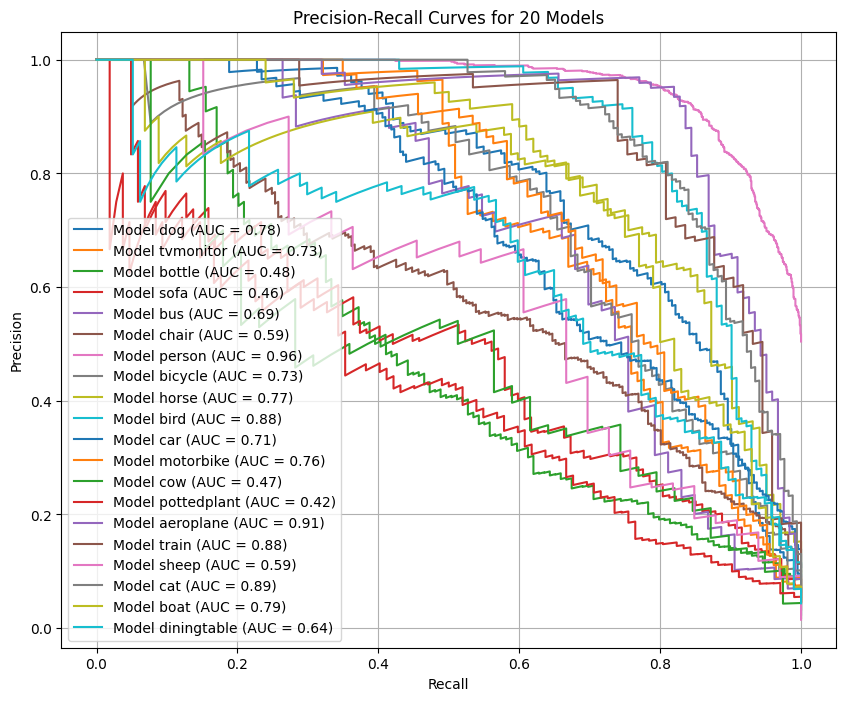

In [8]:
THRESHOLD = 0.5
metrics = []
for _label in os.listdir('models'):
    label = _label.removesuffix('.keras')
    _, val_gen = create_data_generators(df, label)
    model = BinaryModel(label, folder_path='models')
    
    y_pred = model.predict(val_gen)
    p, r, _ = precision_recall_curve(val_gen.labels, y_pred)
    _auc = auc(r, p)
    metric = {'pr' : (p, r), 'auc' : _auc, 'label' : label }
    metrics.append(metric)

plt.figure(figsize=(10, 8))

for i, metric in enumerate(metrics):
    p, r = metric['pr']
    auc = metric['auc']
    label = metric['label']
    plt.plot(r, p, label=f'Model {label} (AUC = {auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for 20 Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Mean Average Precision

In [10]:
print("mAP", np.mean([item['auc'] for item in metrics]))

mAP 0.7068901073863385
